# Purpose

The goal of this notebook is to pull down Centers for Medicare and Medicaid Services (CMS) data on hospital-level variables (e.g. the amount of times patients have serious falls in a given reporting period). This notebook focuses purely on the data wrangling and exploration steps of the Phase I analysis (please see the project's [README](README.md) for info on the Phases of this project). A separate notebook handles the more advanced modeling work for both Phases I and II. 

# Background

CMS collects are sorts of information on US hospitals as part of its role as a federally-managed insurance organization. I was inspired to think about modeling hospital outcomes by the news in early 2019 that CMS had mandated that all US hospital chargemaster data must be published online in machine-readable format on hospital websites. These tables provide the pre-insurance-negotiation prices for all procedures and consumables in a gvien hospital.

Upon digging a bit into the chargemasters data I could find (and forking [a very helpful repo](https://github.com/vsoch/hospital-chargemaster) that had done a lot of the heavy lifting parsing many hospitals' chargemaster data), I determined that the cleaning process for those data (including discerning what procedures and consumables were equivalent items, due to the shorthand used to describe them in many instances) would be a bigger task, so  I split the work into two phases as described in the README.

This notebook, as mentioned before, is concerned with Phase I's data collection steps.

# Pulling Data from CMS API

The first step in this endeavor is to pull down as much relevant (and up to date) data as I can from [the CMS API covering hospitals](https://data.medicare.gov/data/hospital-compare). As I pull the data down, I'll also do some basic cleanup, such as removing columns that seem unhelpful, etc.

In [134]:
# Package import

#import autoreload
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import json
import requests
import numpy as np
import pandas as pd
import plotly.express as px
import geopandas as gpd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Pull app token to identify the analysis from private key file
# Note that data can be pulled without a token, but limits are put on the number of requests
# and the data stream is throttled

# I recommend that anyone attempting to reproduce this work generate their own token to do so
# The returned APP_TOKEN is a string

APP_TOKEN = pd.read_json("secure_keys/CMS_app_token.json").loc[0,'App Token']

In [318]:
def query_CMS(dataset_url, query_params={"$select": "*"}, app_token=APP_TOKEN, response=False,
             drop_location_data=False, gold_standard_IDs=None):
    '''
    Queries the CMS API for a specific dataset and returns the data 
    from the query as a pandas DataFrame
    
    Inputs
    ------
    dataset_url: str. URL of the dataset being queried (CMS uses different source
        URLs for each dataset instead of exposing one big database via a single URL).
        Options for different dataset URLs can be found by exploring the documentation
        at https://data.medicare.gov/data/hospital-compare.
        
    query_params: dict. Represents the parameters that can be used to narrow queries from the API
        Don't explicitly include the app token in this, as it is added as part of execution of 
        this function. Also don't include a LIMIT parameter, as this will be calculated automatically
        and used to pull down the full dataset.
        
    response: bool. If True, returns a tuple, with DataFrame as first element and 
        response object as second
        
    drop_location_data: bool. If True, drops columns with "location" in the title, presumably
        because they are redundant with information stored in another DataFrame/table, as well
        as standard location-related fields (e.g. address)
        
    gold_standard_IDs: list of str. Values are the string-form provider IDs that are considered
        high-quality because they came from the query that built the gen_info DataFrame
        and are thus our point of reference for all provider IDs in the other datasets.
        Any records with IDs not in this list will be removed as part of the query process
        unless this is set to None.
    
    
    Returns
    -------
    pandas DataFrame with queried data and relevant metadata OR tuple of format (df, resopnse_obj).
        See response input above for more info. Will return None if query throws an error
'''

    # Query to figure out how many records there are and set LIMIT based on them
    r_count = requests.get(dataset_url, params={"$select": "COUNT(*)",
                                          "$$app_token": APP_TOKEN})
    num_rows = int(r_count.json()[0]['COUNT'])
    query_params["$limit"] = num_rows
    
    # Add the app token to avoid throttled queries
    query_params["$$app_token"] = app_token

    
    # Perform the main query
    r = requests.get(dataset_url, params=query_params)

    # Check that query didn't throw any errors
    if r.status_code == requests.codes.ok:
        print("Query successful!")
    else:
        print(f"Query failed with status code {r.status_code}")
        return None
    
    # Convert JSON to DataFrame and replace "Not Available" with np.nan
    df = pd.DataFrame.from_dict(r.json()).replace({'Not Available': np.nan})
    
    # If provider_id is present, sort by it
    if gen_info.columns.str.contains('provider_id').sum() > 0:
        df = df.sort_values('provider_id').reset_index(drop=True)
    
    # Make sure df column order is same as recommended order from API
    # (from_dict() tends to return columns in alphabetical order)
    df = df.loc[:, list(r.json()[0].keys())]
        
    # Includes dataset last updated datetime as a column
    df['Dataset Last Updated'] = pd.to_datetime(r.headers['X-SODA2-Truth-Last-Modified'])
    
    # Drop the columns including ":@computed" in name as they are not helpful
    df.drop(columns=list(df.columns[df.columns.str.contains(':@computed')]), 
            inplace=True)
    
    # If directed to do so, drop location columns
    if drop_location_data:
        df.drop(columns=list(df.columns[df.columns.str.contains('location')]),
                inplace=True)
        
        df.drop(columns=['address', 'city', 'state', 
                         'zip_code', 'county_name', 
                         'phone_number'],
               inplace=True)
        
    # Remove any records with provider IDs we deem invalid
    if gold_standard_IDs:
        bad_IDs = df[~df['provider_id'].isin(gold_standard_IDs)].index
        df.drop(index=bad_IDs, inplace=True)
        
        # Convert to int
        df['provider_id'] = df['provider_id'].astype(int)
    
    if response:
        return (df, r)
    else:    
        return df

## Choosing the Datasets

Herein I pull in the relevant metadata for the different datasets I'm most interested in for the purposes of this project, specifically those whose metadata I wrote into the `metadata.csv` file. There are quite a few other CMS datasets available than just these that I'm using, so I recommend that anyone interested explore them more deeply!

In [5]:
metadata = pd.read_csv('metadata.csv', encoding = 'latin-1')
metadata

Dataset Name  \
0                                 Footnote Crosswalk   
1                       Hospital General Information   
2                Complications and Deaths - Hospital   
3        Healthcare Associated Infections - Hospital   
4            Hospital Readmissions Reduction Program   
5  Medicare Spending Per Beneficiary Ð Hospital A...   
6           Outpatient Imaging Efficiency - Hospital   
7                 Patient survey (HCAHPS) - Hospital   
8                     Structural Measures - Hospital   

                                    API Endpoint URL  \
0  https://data.medicare.gov/resource/sbph-xiia.json   
1  https://data.medicare.gov/resource/rbry-mqwu.json   
2  https://data.medicare.gov/resource/ukfj-tt6v.json   
3  https://data.medicare.gov/resource/ppaw-hhm5.json   
4  https://data.medicare.gov/resource/kac9-a9fp.json   
5  https://data.medicare.gov/resource/8ckj-r4j6.json   
6  https://data.medicare.gov/resource/72af-b2t9.json   
7  https://data.medicare.gov/resource/rmgi-5fhi.json   
8  https://data.medicare.gov/resource/w5ci-7egs.json   

                                         Description  
0  List of footnotes referenced in many datasets ...  
1  A list of all hospitals that have been registe...  
2  Complications and deaths data provided by the ...  
3  Hospital-provided data. These measures are dev...  
4  Measures of frequency of patient readmissions ...  
5  The Medicare Spending Per Beneficiary (MSPB) M...  
6  Hospital-provided data about the use of medica...  
7  A list of hospital ratings for the Hospital Co...  
8  A list of hospitals and the structural measure...

## Pulling in Footnote Definitions

CMS appears to have standardized footnotes that contextualize their measurements. These include things like `'The number of cases/patients is too few to report.'` These appear to be included with most measurements, regardless of the granularity of the dataset in question (although they are often missing) and sometimes more than one is even included in a comma-delimited list! Let's pull this mapping in and create a parser to identify what the various IDs mean so we can draw on that knowledge as needed.

In [6]:
footnote_mapping = query_CMS(metadata.loc[0, 'API Endpoint URL'])
footnote_mapping.head()

Query successful!


footnote                                      footnote_text  \
0        1  The number of cases/patients is too few to rep...   
1        2  Data submitted were based on a sample of cases...   
2        3  Results are based on a shorter time period tha...   
3        4   Data suppressed by CMS for one or more quarters.   
4        5  Results are not available for this reporting p...   

       Dataset Last Updated  
0 2019-07-30 06:19:20+00:00  
1 2019-07-30 06:19:20+00:00  
2 2019-07-30 06:19:20+00:00  
3 2019-07-30 06:19:20+00:00  
4 2019-07-30 06:19:20+00:00

In [7]:
footnote_mapping.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 3 columns):
footnote                30 non-null object
footnote_text           30 non-null object
Dataset Last Updated    30 non-null datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), object(2)
memory usage: 800.0+ bytes


In [8]:
def parse_footnote(footnote_ids, footnote_defs):
    '''
    As some of the CMS datasets provide the footnote ID number(s) 
    as a comma-delimited list of integers (unless there is only one or none),
    it is necessary to use the footnote definitions DataFrame to decode them
    if we need to understand any caveats present

    Inputs
    ------
    footnote_ids: single int as a str or list of comma-delimited ints as a str. The ID(s) of 
        relevant footnotes for a record

    footnote_defs: pandas DataFrame with mapping of footnote IDs to human-readable
        footnote text


    Returns
    -------
    pandas DataFrame of descriptions with each ID and its corresponding description text
    '''
    # Remove any spaces and make split into list based on commas
    # Single ID values will take form '1' -> ['1']
    footnote_ids = footnote_ids.replace(' ', '').split(',')

    return footnote_defs.loc[footnote_defs['footnote'].isin(footnote_ids),
                             ['footnote', 'footnote_text']]


## General Hospital Data

This dataset includes a bunch of high-level data about the hospitals registered with CMS, like their physical addresses, phone numbers, names, high-level quality measures (including `mortality_national_comparison`), and perhaps most importantly, the `provider_id` field. This last item is particularly important as it is what will allow us to refer to each hospital in a memory-efficient way (via integers instead of strings) and will serve as the primary key for hospitals in any database implementation I may design.

In [9]:
gen_info, r = query_CMS(metadata.loc[1, 'API Endpoint URL'], response=True)
gen_info.head(20)

Query successful!


provider_id                        hospital_name  \
0       010001     SOUTHEAST ALABAMA MEDICAL CENTER   
1       010005        MARSHALL MEDICAL CENTER SOUTH   
2       010006         NORTH ALABAMA MEDICAL CENTER   
3       010007             MIZELL MEMORIAL HOSPITAL   
4       010008          CRENSHAW COMMUNITY HOSPITAL   
5       010011                    ST VINCENT'S EAST   
6       010012       DEKALB REGIONAL MEDICAL CENTER   
7       010016        SHELBY BAPTIST MEDICAL CENTER   
8       010018  UAB CALLAHAN EYE HOSPITAL AUTHORITY   
9       010019       HELEN KELLER MEMORIAL HOSPITAL   
10      010021                  DALE MEDICAL CENTER   
11      010022        FLOYD CHEROKEE MEDICAL CENTER   
12      010023         BAPTIST MEDICAL CENTER SOUTH   
13      010024        JACKSON HOSPITAL & CLINIC INC   
14      010029          EAST ALABAMA MEDICAL CENTER   
15      010032   TANNER MEDICAL CENTER-EAST ALABAMA   
16      010033       UNIVERSITY OF ALABAMA HOSPITAL   
17      010034               COMMUNITY HOSPITAL INC   
18      010035      CULLMAN REGIONAL MEDICAL CENTER   
19      010036                     ANDALUSIA HEALTH   

                            address        city state zip_code county_name  \
0            1108 ROSS CLARK CIRCLE      DOTHAN    AL    36301     HOUSTON   
1        2505 U S HIGHWAY 431 NORTH        BOAZ    AL    35957    MARSHALL   
2               1701 VETERANS DRIVE    FLORENCE    AL    35630  LAUDERDALE   
3                     702 N MAIN ST         OPP    AL    36467   COVINGTON   
4               101 HOSPITAL CIRCLE     LUVERNE    AL    36049    CRENSHAW   
5        50 MEDICAL PARK EAST DRIVE  BIRMINGHAM    AL    35235   JEFFERSON   
6              200 MED CENTER DRIVE  FORT PAYNE    AL    35968     DE KALB   
7           1000 FIRST STREET NORTH   ALABASTER    AL    35007      SHELBY   
8   1720 UNIVERSITY BLVD, SUITE 500  BIRMINGHAM    AL    35233   JEFFERSON   
9      1300 SOUTH MONTGOMERY AVENUE   SHEFFIELD    AL    35660     COLBERT   
10                 126 HOSPITAL AVE       OZARK    AL    36360        DALE   
11                 400 NORTHWOOD DR      CENTRE    AL    35960    CHEROKEE   
12        2105 EAST SOUTH BOULEVARD  MONTGOMERY    AL    36116  MONTGOMERY   
13                 1725 PINE STREET  MONTGOMERY    AL    36106  MONTGOMERY   
14           2000 PEPPERELL PARKWAY     OPELIKA    AL    36801         LEE   
15           1032 MAIN STREET SOUTH     WEDOWEE    AL    36278    RANDOLPH   
16            619 SOUTH 19TH STREET  BIRMINGHAM    AL    35233   JEFFERSON   
17              805 FRIENDSHIP ROAD   TALLASSEE    AL    36078      ELMORE   
18         1912 ALABAMA HIGHWAY 157     CULLMAN    AL    35058     CULLMAN   
19     849 SOUTH THREE NOTCH STREET   ANDALUSIA    AL    36420   COVINGTON   

   phone_number         hospital_type  \
0    3347938701  Acute Care Hospitals   
1    2565938310  Acute Care Hospitals   
2    2567688400  Acute Care Hospitals   
3    3344933541  Acute Care Hospitals   
4    3343353374  Acute Care Hospitals   
5    2058383122  Acute Care Hospitals   
6    2568453150  Acute Care Hospitals   
7    2056208100  Acute Care Hospitals   
8    2053258100  Acute Care Hospitals   
9    2563864556  Acute Care Hospitals   
10   3347742601  Acute Care Hospitals   
11   2569275531  Acute Care Hospitals   
12   3342882100  Acute Care Hospitals   
13   3342938000  Acute Care Hospitals   
14   3347493411  Acute Care Hospitals   
15   2563572111  Acute Care Hospitals   
16   2059344011  Acute Care Hospitals   
17   3342836541  Acute Care Hospitals   
18   2567372000  Acute Care Hospitals   
19   3342228466  Acute Care Hospitals   

                             hospital_ownership  ...  \
0   Government - Hospital District or Authority  ...   
1   Government - Hospital District or Authority  ...   
2   Government - Hospital District or Authority  ...   
3                Voluntary non-profit - Private  ...   
4                                   Proprietary  ...   
5         

In [207]:
# Store provider_id strings for later use as gold standard
valid_IDs = list(gen_info['provider_id'].unique())

Query successful!


In [10]:
gen_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5334 entries, 0 to 5333
Data columns (total 37 columns):
provider_id                                                      5334 non-null object
hospital_name                                                    5334 non-null object
address                                                          5334 non-null object
city                                                             5334 non-null object
state                                                            5334 non-null object
zip_code                                                         5334 non-null object
county_name                                                      5334 non-null object
phone_number                                                     5334 non-null object
hospital_type                                                    5334 non-null object
hospital_ownership                                               5334 non-null object
emergency_services               

Hmmm...it looks like some of these columns are redundant and/or not useful (as they're not described in the dataset landing page and thus could mean anything). Let's drop them to make things easier.

In [11]:
# Dropping redundant location data
cols = list(gen_info.columns[gen_info.columns.str.contains('location_')])
gen_info.drop(columns=cols, inplace=True)

gen_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5334 entries, 0 to 5333
Data columns (total 30 columns):
provider_id                                                      5334 non-null object
hospital_name                                                    5334 non-null object
address                                                          5334 non-null object
city                                                             5334 non-null object
state                                                            5334 non-null object
zip_code                                                         5334 non-null object
county_name                                                      5334 non-null object
phone_number                                                     5334 non-null object
hospital_type                                                    5334 non-null object
hospital_ownership                                               5334 non-null object
emergency_services               

**Much better! Counting the extra column I added (`Dataset Last Updated`), this matches the number of columns we'd expect from the dataset landing page.** Let's now parse through these columns and make sure they are of the right type, etc.

In [12]:
# IDs don't seem to be anything other than ints, so let's make them that!
col = 'provider_id'

print(f"There are {gen_info[col].isnull().sum()} nulls in {col} prior to typecasting")
gen_info[col] = gen_info[col].astype(int)
print(f"There are {gen_info[col].isnull().sum()} nulls in {col} after typecasting")

There are 0 nulls in provider_id prior to typecasting
There are 0 nulls in provider_id after typecasting


In [13]:
# Can `meets_critera...` be bool?
gen_info['meets_criteria_for_meaningful_use_of_ehrs'].value_counts()

True    3710
Name: meets_criteria_for_meaningful_use_of_ehrs, dtype: int64

In [14]:
# Change `meets_critera...` to be bool with nan = False
gen_info['meets_criteria_for_meaningful_use_of_ehrs'].fillna(False, inplace=True)

In [15]:
# IDs don't seem to be anything other than ints, so let's make them that!
col = 'meets_criteria_for_meaningful_use_of_ehrs'

print(f"There are {gen_info[col].isnull().sum()} nulls in {col} prior to typecasting")
gen_info[col] = gen_info[col].astype(bool)
print(f"There are {gen_info[col].isnull().sum()} nulls in {col} after typecasting")

There are 0 nulls in meets_criteria_for_meaningful_use_of_ehrs prior to typecasting
There are 0 nulls in meets_criteria_for_meaningful_use_of_ehrs after typecasting


In [16]:
gen_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5334 entries, 0 to 5333
Data columns (total 30 columns):
provider_id                                                      5334 non-null int64
hospital_name                                                    5334 non-null object
address                                                          5334 non-null object
city                                                             5334 non-null object
state                                                            5334 non-null object
zip_code                                                         5334 non-null object
county_name                                                      5334 non-null object
phone_number                                                     5334 non-null object
hospital_type                                                    5334 non-null object
hospital_ownership                                               5334 non-null object
emergency_services                

In [17]:
# Ratings should be integer or float...right?
col = 'hospital_overall_rating'

print(
    f"There are {gen_info[col].isnull().sum()} nulls in {col} prior to typecasting")
pd.to_numeric(gen_info[col], errors='coerce').isnull().sum()
print(
    f"There are {pd.to_numeric(gen_info[col], errors='raise').isnull().sum()} \
    nulls in {col} after to typecasting")


There are 1631 nulls in hospital_overall_rating prior to typecasting
There are 1631     nulls in hospital_overall_rating after to typecasting


In [18]:
# Do the conversion to numeric
gen_info[col] = pd.to_numeric(gen_info[col], errors='raise')

gen_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5334 entries, 0 to 5333
Data columns (total 30 columns):
provider_id                                                      5334 non-null int64
hospital_name                                                    5334 non-null object
address                                                          5334 non-null object
city                                                             5334 non-null object
state                                                            5334 non-null object
zip_code                                                         5334 non-null object
county_name                                                      5334 non-null object
phone_number                                                     5334 non-null object
hospital_type                                                    5334 non-null object
hospital_ownership                                               5334 non-null object
emergency_services                

In [19]:
# Explore the rest of the columns through some quick automatic EDA courtesy of pandas-profiling
import pandas_profiling as pdp
pdp.ProfileReport(gen_info)

**A few things to note from this exploration:**

1. There are a whole lot of missing values (nearly 27% of all data)! ...but these likely mostly come from things like the footnotes.
2. All of the ratings beyond the general hospital star rating correspond to categorical string descriptions
3. There are some hospitals that have the same name, but different provider IDs
    * There are 5,334 unique IDs
    * There are only 5,149 unique hospital names
    * Most common hospital names are "Memorial Hospital", "Community Memorial Hospital", and "St. Joseph Hospital" (top 3)
    * **Unfortunately, this means it will be hard to map hospital names from other datasets (e.g. chargemaster data) to these unique provider IDs. But we'll do what we can!**
4. I need to convert this from a pandas DataFrame to a GeoPandas GeoDataFrame so we can use the data in `location`

In [20]:
# Let's take a quick look at the footnotes and, if we don't see anything alarming,
# go ahead and drop them

foot_cols = gen_info.columns[gen_info.columns.str.contains('footnote')]

for col in foot_cols:
    print(f"Column: {col}")
    print(gen_info[col].value_counts().index)
    print("\n\n")

Column: hospital_overall_rating_footnote
Index(['There are too few measures or measure groups reported to calculate a star rating or measure group score.',
       'Data are shown only for hospitals that participate in the Inpatient Quality Reporting (IQR) and Outpatient Quality Reporting (OQR) programs.',
       'This hospital's star rating only includes data reported on inpatient services.',
       'Results are not available for this reporting period.',
       'The data are based on claims that the hospital or facility submitted to CMS. The hospital or facility has reported discrepancies in their claims data.'],
      dtype='object')



Column: mortality_national_comparison_footnote
Index(['Results are not available for this reporting period.',
       'Data are shown only for hospitals that participate in the Inpatient Quality Reporting (IQR) and Outpatient Quality Reporting (OQR) programs.',
       'There are too few measures or measure groups reported to calculate a star rating or m

**As it doesn't look like we can do much about these in terms of improving our data's quality, we'll drop them.**

In [21]:
gen_info.drop(columns=foot_cols, inplace=True)
gen_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5334 entries, 0 to 5333
Data columns (total 22 columns):
provider_id                                             5334 non-null int64
hospital_name                                           5334 non-null object
address                                                 5334 non-null object
city                                                    5334 non-null object
state                                                   5334 non-null object
zip_code                                                5334 non-null object
county_name                                             5334 non-null object
phone_number                                            5334 non-null object
hospital_type                                           5334 non-null object
hospital_ownership                                      5334 non-null object
emergency_services                                      5334 non-null bool
meets_criteria_for_meaningful_use_of_ehrs        

In [22]:
gen_info.isnull().sum().sum() / (len(gen_info) * len(gen_info.columns))

0.131770460510618

**Looks like we cut the percentage of missing values by more than half** by dropping the footnote columns. Great!

Let's now take a look at the quality measures.

In [122]:
# Take a look at the different values available for the quality measures columns

measures = ['mortality_national_comparison',
            'safety_of_care_national_comparison', 
            'readmission_national_comparison',
            'patient_experience_national_comparison',
            'effectiveness_of_care_national_comparison',
            'timeliness_of_care_national_comparison',
            'efficient_use_of_medical_imaging_national_comparison']

for measure in measures:
    print(f"Column: {measure}\n")
    print(gen_info[measure].value_counts())
    print("\n\n")

Column: mortality_national_comparison

Same as the national average    2653
Above the national average       384
Below the national average       349
Name: mortality_national_comparison, dtype: int64



Column: safety_of_care_national_comparison

Above the national average      1183
Below the national average       899
Same as the national average     544
Name: safety_of_care_national_comparison, dtype: int64



Column: readmission_national_comparison

Above the national average      1504
Below the national average      1353
Same as the national average    1003
Name: readmission_national_comparison, dtype: int64



Column: patient_experience_national_comparison

Above the national average      1174
Same as the national average    1154
Below the national average      1095
Name: patient_experience_national_comparison, dtype: int64



Column: effectiveness_of_care_national_comparison

Same as the national average    3360
Below the national average       307
Above the national average     

Originally I was thinking that I'd map these text ratings to ordinal codes, but I'm trying to keep this analysis from using any derived values if I can (e.g. instead of using another model's measure of a feature like safety, I'd rather have it be clearly derived in this analysis using measurable values, like the number of broken hopsital beds for the safety example).

So, I'm going to drop these features to avoid using these derived values in favor of keeping any engineered features clearly constructed within this analysis. That being said, I'm going to retain `hospital_overall_rating` for now as the Medicare data dictionary claims it is derived using data from over 60 variables, suggesting it contains a good bit more information than the data I'm using here and thus is far less redundant of a measure than these others.

In [123]:
gen_info.drop(columns=measures, inplace=True)

In [124]:
gen_info.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5334 entries, 0 to 5333
Data columns (total 15 columns):
provider_id                                  5334 non-null int64
hospital_name                                5334 non-null object
address                                      5334 non-null object
city                                         5334 non-null object
state                                        5334 non-null object
zip_code                                     5334 non-null object
county_name                                  5334 non-null object
phone_number                                 5334 non-null object
hospital_type                                5334 non-null object
hospital_ownership                           5334 non-null object
emergency_services                           5334 non-null bool
meets_criteria_for_meaningful_use_of_ehrs    5334 non-null bool
hospital_overall_rating                      3703 non-null float64
location                       

Alrighty, now that that's done, we'll finish up by making that `location` data useful for mapping by converting it to `shapely` objects and pushing the whole thing into a GeoDataFrame

In [23]:
gen_info.loc[0,'location']#['coordinates']

{'type': 'Point', 'coordinates': [-85.361725, 31.214058]}

In [24]:
# Are all of these Point-type? Likely, but we should verify

gen_info['location'].dropna().apply(lambda x: x['type']).value_counts()

Point    4933
Name: location, dtype: int64

In [25]:
from shapely import wkt

def construct_wkt(location):
    '''
    Transform the dicts in gen_info['location'] into WKT (well-known text) coordinate
    strings and convert to shapely objects for later conversion of the DataFrame into a 
    GeoDataFrame. It is assumed that all geometries extracted are Points.
    
    This function is meant to be used via pd.Series.apply()
    
    
    Inputs
    ------
    location: dict with keys "type" and "coordinates" with the latter being a 2-element list of floats
    
    
    Returns
    -------
    shapely Point object
    '''
    
    # Return null if null
    if location is np.nan:
        return location
    
    long = location['coordinates'][0]
    lat = location['coordinates'][1]
    
    long_lat_str = "POINT(" + str(long) + " " + str(lat) + ")"

    return wkt.loads(long_lat_str)

In [27]:
gen_info['location'] = gen_info['location'].apply(construct_wkt)

TypeError: 'Point' object is not subscriptable

In [34]:
gen_info['location'].apply(lambda x: type(x)).value_counts()

<class 'shapely.geometry.point.Point'>    4933
<class 'float'>                            401
Name: location, dtype: int64

...not sure why that's throwing an error, but it looks like it did what I was hoping for, so I won't worry too much about it!

In [38]:
# Transform from standard pandas DataFrame to GeoDataFrame and 
# set to have Web Mercator CRS for contextily
gen_info = gpd.GeoDataFrame(gen_info, geometry='location', crs = 'epsg:3857')

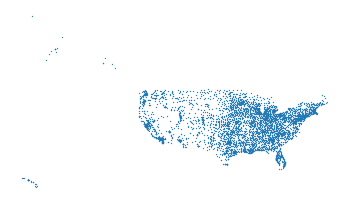

In [71]:
# So what do the hospitals locations look like after all of that?
import contextily as ctx

#fig, ax = plt.subplots()

ax = gen_info.dropna(subset=['location']).plot(markersize=1)
#ctx throwing tile URL error, skipping for now
#ctx.add_basemap(ax)
ax.set_axis_off()

That looks about right! It would be better with a background context map, but oh well, that's not working right now...

## Complications and Deaths

As I'm most interested in predicting patient outcomes so that patients have the best possible chance of picking a good hospital for themselves, complications and deaths seem extremely relevant, so let's include those!

I should note here that, as of this point, I'm still exploring the data to see what target variable for prediction is most interesting to me. There are a number of candidates!

In [267]:
comps_deaths, r = query_CMS(metadata.loc[2, 'API Endpoint URL'], 
                            response=True, 
                            drop_location_data=True)
comps_deaths.head(20)

Query successful!


provider_id                     hospital_name                     address  \
0       010001  SOUTHEAST ALABAMA MEDICAL CENTER      1108 ROSS CLARK CIRCLE   
1       010001  SOUTHEAST ALABAMA MEDICAL CENTER      1108 ROSS CLARK CIRCLE   
2       010001  SOUTHEAST ALABAMA MEDICAL CENTER      1108 ROSS CLARK CIRCLE   
3       010001  SOUTHEAST ALABAMA MEDICAL CENTER      1108 ROSS CLARK CIRCLE   
4       010001  SOUTHEAST ALABAMA MEDICAL CENTER      1108 ROSS CLARK CIRCLE   
5       010001  SOUTHEAST ALABAMA MEDICAL CENTER      1108 ROSS CLARK CIRCLE   
6       010001  SOUTHEAST ALABAMA MEDICAL CENTER      1108 ROSS CLARK CIRCLE   
7       010001  SOUTHEAST ALABAMA MEDICAL CENTER      1108 ROSS CLARK CIRCLE   
8       010001  SOUTHEAST ALABAMA MEDICAL CENTER      1108 ROSS CLARK CIRCLE   
9       010001  SOUTHEAST ALABAMA MEDICAL CENTER      1108 ROSS CLARK CIRCLE   
10      010001  SOUTHEAST ALABAMA MEDICAL CENTER      1108 ROSS CLARK CIRCLE   
11      010001  SOUTHEAST ALABAMA MEDICAL CENTER      1108 ROSS CLARK CIRCLE   
12      010001  SOUTHEAST ALABAMA MEDICAL CENTER      1108 ROSS CLARK CIRCLE   
13      010001  SOUTHEAST ALABAMA MEDICAL CENTER      1108 ROSS CLARK CIRCLE   
14      010001  SOUTHEAST ALABAMA MEDICAL CENTER      1108 ROSS CLARK CIRCLE   
15      010001  SOUTHEAST ALABAMA MEDICAL CENTER      1108 ROSS CLARK CIRCLE   
16      010001  SOUTHEAST ALABAMA MEDICAL CENTER      1108 ROSS CLARK CIRCLE   
17      010001  SOUTHEAST ALABAMA MEDICAL CENTER      1108 ROSS CLARK CIRCLE   
18      010001  SOUTHEAST ALABAMA MEDICAL CENTER      1108 ROSS CLARK CIRCLE   
19      010005     MARSHALL MEDICAL CENTER SOUTH  2505 U S HIGHWAY 431 NORTH   

      city state zip_code county_name phone_number  \
0   DOTHAN    AL    36301     HOUSTON   3347938701   
1   DOTHAN    AL    36301     HOUSTON   3347938701   
2   DOTHAN    AL    36301     HOUSTON   3347938701   
3   DOTHAN    AL    36301     HOUSTON   3347938701   
4   DOTHAN    AL    36301     HOUSTON   3347938701   
5   DOTHAN    AL    36301     HOUSTON   3347938701   
6   DOTHAN    AL    36301     HOUSTON   3347938701   
7   DOTHAN    AL    36301     HOUSTON   3347938701   
8   DOTHAN    AL    36301     HOUSTON   3347938701   
9   DOTHAN    AL    36301     HOUSTON   3347938701   
10  DOTHAN    AL    36301     HOUSTON   3347938701   
11  DOTHAN    AL    36301     HOUSTON   3347938701   
12  DOTHAN    AL    36301     HOUSTON   3347938701   
13  DOTHAN    AL    36301     HOUSTON   3347938701   
14  DOTHAN    AL    36301     HOUSTON   3347938701   
15  DOTHAN    AL    36301     HOUSTON   3347938701   
16  DOTHAN    AL    36301     HOUSTON   3347938701   
17  DOTHAN    AL    36301     HOUSTON   3347938701   
18  DOTHAN    AL    36301     HOUSTON   3347938701   
19    BOAZ    AL    35957    MARSHALL   2565938310   

                                         measure_name  \
0           Perioperative Hemorrhage or Hematoma Rate   
1                Death rate for CABG surgery patients   
2                   Death rate for pneumonia patients   
3   Deaths among Patients with Serious Treatable C...   
4               Death rate for heart failure patients   
5   A wound that splits open after surgery on the ...   
6    Accidental cuts and tears from medical treatment   
7   Rate of complications for hip/knee replacement...   
8              Postoperative Respiratory Failure Rate   
9                        Death rate for COPD patients   
10  Postoperative Acute Kidney Injury Requiring Di...   
11                                     Pressure sores   
12               Death rate for heart attack patients   
13                  Serious blood clots after surgery   
14            Collapsed lung due to medical treatment   
15               Broken hip from a fall after surgery   
16                     Death rate for stroke patients   
17               Blood stream infection after surgery   
18                              Serious complications   
19  Rate of complications for hip/knee replacem

In [268]:
comps_deaths.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91889 entries, 0 to 91888
Data columns (total 18 columns):
provider_id             91889 non-null object
hospital_name           91889 non-null object
address                 91889 non-null object
city                    91889 non-null object
state                   91889 non-null object
zip_code                91889 non-null object
county_name             91889 non-null object
phone_number            91889 non-null object
measure_name            91889 non-null object
measure_id              91889 non-null object
compared_to_national    62862 non-null object
denominator             51106 non-null object
score                   54316 non-null object
lower_estimate          54316 non-null object
higher_estimate         54316 non-null object
measure_start_date      91889 non-null object
measure_end_date        91889 non-null object
Dataset Last Updated    91889 non-null datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), object(17)
memory 

This is a nice big dataset, great! Let's do some clean up. Some items I see immediately that need to be dealt with:

1. There are a number of columns repeated here that are redundant with what we're already storing in `gen_info`, so I'll drop them since I can always join with `gen_info` on `provider_id` if I need them later. Columns I can drop:
    * `hospital_name`
    * `address`, `city`, `state`, `zip_code`, `county_name`, and `phone_number`
    
2. `measure_start_date` and `measure_end_date` need to be made into datetime columns
3. `denominator`, `score`, `lower_estimate`, and `higher_estimate` need to be made numeric
    * I don't know what all of these are or what values for them are reasonable vs. outlier vs. nonsensical, so I'll need to read the [Medicare data dictionary before doing more with those](Medicare_Hospitals_DataDictionary.pdf)
4. As with all of these datsets, I need to check that `provider_id` is reliable as a foreign key

In [269]:
# Drop redundant columns
redundant_cols = ['hospital_name', 'address', 'city', 'state', 'zip_code',
                 'county_name', 'phone_number']

comps_deaths.drop(columns=redundant_cols, inplace=True)

In [270]:
# Convert measure_start_date and measure_end_date to datetime
comps_deaths[['measure_start_date', 'measure_end_date']] = \
comps_deaths[['measure_start_date', 'measure_end_date']].apply(pd.to_datetime)

In [271]:
comps_deaths['compared_to_national'].value_counts()

No Different Than the National Rate     48735
Number of Cases Too Small                8546
No Different Than the National Value     2916
Worse Than the National Rate             1393
Better Than the National Rate             978
Worse Than the National Value             200
Better Than the National Value             94
Name: compared_to_national, dtype: int64

The `compared_to_national` feature seems to be the main linkage between a `score` value and the national average. That said, it seems that the national average is likely calculated simply using the data in this table, but let's check that quickly. If it is, then we'll simply need to know what criteria were used to determine if something is "the same as the national average" vs. higher or lower (since I doubt that lots of hospitals are hitting the number right on the mark with no +/- wiggle room/tolerance).

We'll look first at `measure_name == Deaths among Patients with Serious Treatable Complications after Surgery` as the Hospital Compare website indicates this should have a national average value of 163.01 (which is in units of "per 1000 patients discharged" by the way).

In [273]:
# Need to make the scores float so we can actually do calculations with them
comps_deaths['score'] = comps_deaths['score'].astype(float)

In [289]:
col = 'Deaths among Patients with Serious Treatable Complications after Surgery'

comps_deaths.groupby('measure_name')['score'].describe().loc[col]

count    1786.000000
mean      162.931965
std        19.382236
min        91.710000
25%       150.045000
50%       162.035000
75%       174.400000
max       242.870000
Name: Deaths among Patients with Serious Treatable Complications after Surgery, dtype: float64

**Our column of interest has an average of 162.93, which is quite close to the quoted national rate value of 163.01, so it looks like we can effectively use the averages from the data to determine what the national comparison value being used is.**

OK, so let's now try to reverse engineer what the tolerance is for something to be declared "same as national rate" vs. different. First things first, let's take a look at the higher and lower estimate values for each measure to see if they change across hospitals for some reason.

In [278]:
comps_deaths[['lower_estimate', 'higher_estimate', 'denominator']] = \
comps_deaths[['lower_estimate', 'higher_estimate', 'denominator']].astype(float)

In [279]:
comps_deaths.groupby('measure_name')[['lower_estimate', 'higher_estimate']].describe()

lower_estimate              \
                                                            count        mean   
measure_name                                                                    
A wound that splits open after surgery on the a...         2743.0    0.048232   
Accidental cuts and tears from medical treatment           2944.0    0.181702   
Blood stream infection after surgery                       2745.0    1.850299   
Broken hip from a fall after surgery                       3183.0    0.018093   
Collapsed lung due to medical treatment                    3187.0    0.057788   
Death rate for CABG surgery patients                       1005.0    1.656915   
Death rate for COPD patients                               3538.0    6.173544   
Death rate for heart attack patients                       2359.0   10.133574   
Death rate for heart failure patients                      3617.0    8.680205   
Death rate for pneumonia patients                          4139.0   12.368326   
Death rate for stroke patients                             2511.0   10.726085   
Deaths among Patients with Serious Treatable Co...         1786.0  119.366786   
Perioperative Hemorrhage or Hematoma Rate                  2965.0    1.174388   
Postoperative Acute Kidney Injury Requiring Dia...         2765.0    0.162868   
Postoperative Respiratory Failure Rate                     2740.0    2.105540   
Pressure sores                                             3164.0    0.113783   
Rate of complications for hip/knee replacement ...         2745.0    1.607322   
Serious blood clots after surgery                          2970.0    1.464451   
Serious complications                                      3210.0    0.651436   

                                                                      \
                                                          std    min   
measure_name                                                           
A wound that splits open after surgery on the a...   0.118647   0.00   
Accidental cuts and tears from medical treatment     0.303769   0.00   
Blood stream infection after surgery                 1.212616   0.00   
Broken hip from a fall after surgery                 0.014364   0.00   
Collapsed lung due to medical treatment              0.055877   0.00   
Death rate for CABG surgery patients                 0.525357   0.70   
Death rate for COPD patients                         0.962489   3.70   
Death rate for heart attack patients                 0.968538   7.10   
Death rate for heart failure patients                1.447668   4.30   
Death rate for pneumonia patients                    1.999880   6.60   
Death rate for stroke patients                       1.403229   6.90   
Deaths among Patients with Serious Treatable Co...  21.128717  59.72   
Perioperative Hemorrhage or Hematoma Rate            0.393115   0.29   
Postoperative Acute Kidney Injury Requiring Dia...   0.312522   0.00   
Postoperative Respiratory Failure Rate               2.689639   0.00   
Pressure sores                                       0.403591   0.00   
Rate of complications for hip/knee replacement ...   0.386819   0.90   
Serious blood clots after surgery                    1.104579   0.00   
Serious complications                                0.209503   0.20   

                                                                              \
                                                         25%     50%     75%   
measure_name                                                                   
A wound that splits open after surgery on the a...    0.0000    0.00    0.00   
Accidental cuts and tears from medical treatment      0.0000    0.00    0.26   
Blood stream infection after surgery                  1.0300    1.51    2.38   
Broken hip from a fall after surgery                  0.0100    0.01    0.03   
Collapsed lung due to medical treatment               0.0200    0.03    0.08   
Death rate for CABG surgery patients       

**How odd, I was expecting these to be the same value for each measure, not having any spread - that's clearly not the case.** I've got a support ticket into the dataset maintainers, hopefully they can explain what's going on here...

For now, let's see if there's any obvious pattern in the values considered to be equivalent, above, or below national rates/values. Note that the means for the low and high estimates are 119 and 206, resp. That may be handy later...

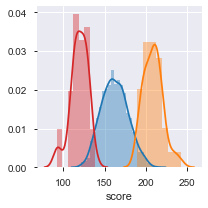

In [282]:
# Take a look at the distribution of our chosen measure scores, colored by the 
# value of `compared_to_national` they're given

g = sns.FacetGrid(comps_deaths[comps_deaths['measure_name'] == col],
             hue='compared_to_national')
g = g.map(sns.distplot, 'score')


In [292]:
comps_deaths.groupby(['measure_name', 'compared_to_national'])['score'].describe().loc[col]

count        mean        std     min  \
compared_to_national                                                         
Better Than the National Rate          45.0  119.251556  10.435702   91.71   
No Different Than the National Rate  1676.0  162.319851  16.079088  121.47   
Number of Cases Too Small               0.0         NaN        NaN     NaN   
Worse Than the National Rate           65.0  208.955385  11.567998  189.40   

                                          25%     50%       75%     max  
compared_to_national                                                     
Better Than the National Rate        113.7800  120.04  126.9900  138.92  
No Different Than the National Rate  150.5975  161.79  173.0925  212.63  
Number of Cases Too Small                 NaN     NaN       NaN     NaN  
Worse Than the National Rate         199.3400  209.35  215.4500  242.87

**Hmmm...it's still not clear to me how the breakpoints for `compare_to_national` are set. Likely it's some sort of confidence-interval-based approach, but I'm not sure exactly what it is.** It's particularly confusing when you realize that there's overlap, as the distribution plot indicated: some high-scoring hospitals can be considered "no different" than the national average when other lower-scoring ones are considered "worse".

Based upon some of the data.medicare.gov documentation, likely this is a reflection of their statistical models taking into account things like hospital geography and risk profile of their patients (e.g. older folks with lots of pre-existing conditions vs. predominantly young and healthy patients). Regardless, following the standards we've set for this project, **I'm going to have to drop the `compared_to_national` column, as it is a derived result using someone else's models and assumptions.** While in many ways it may be relevant, it adds complexity to try and include it, so I won't worry about it for now. I can always add it back in in version 2.0 of the analysis if needed!

In [294]:
# Drop denominator, compared_to_national, lower_estimate, and higher_estimate

comps_deaths.drop(columns=['denominator', 'compared_to_national',
                          'lower_estimate', 'higher_estimate'],
                 inplace=True)

In [295]:
# Drop measure_id as it's redundant and less informative than measure_name

comps_deaths.drop(columns=['measure_id'], inplace=True)

In [296]:
comps_deaths.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91889 entries, 0 to 91888
Data columns (total 6 columns):
provider_id             91889 non-null object
measure_name            91889 non-null object
score                   54316 non-null float64
measure_start_date      91889 non-null datetime64[ns]
measure_end_date        91889 non-null datetime64[ns]
Dataset Last Updated    91889 non-null datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), datetime64[ns](2), float64(1), object(2)
memory usage: 4.2+ MB


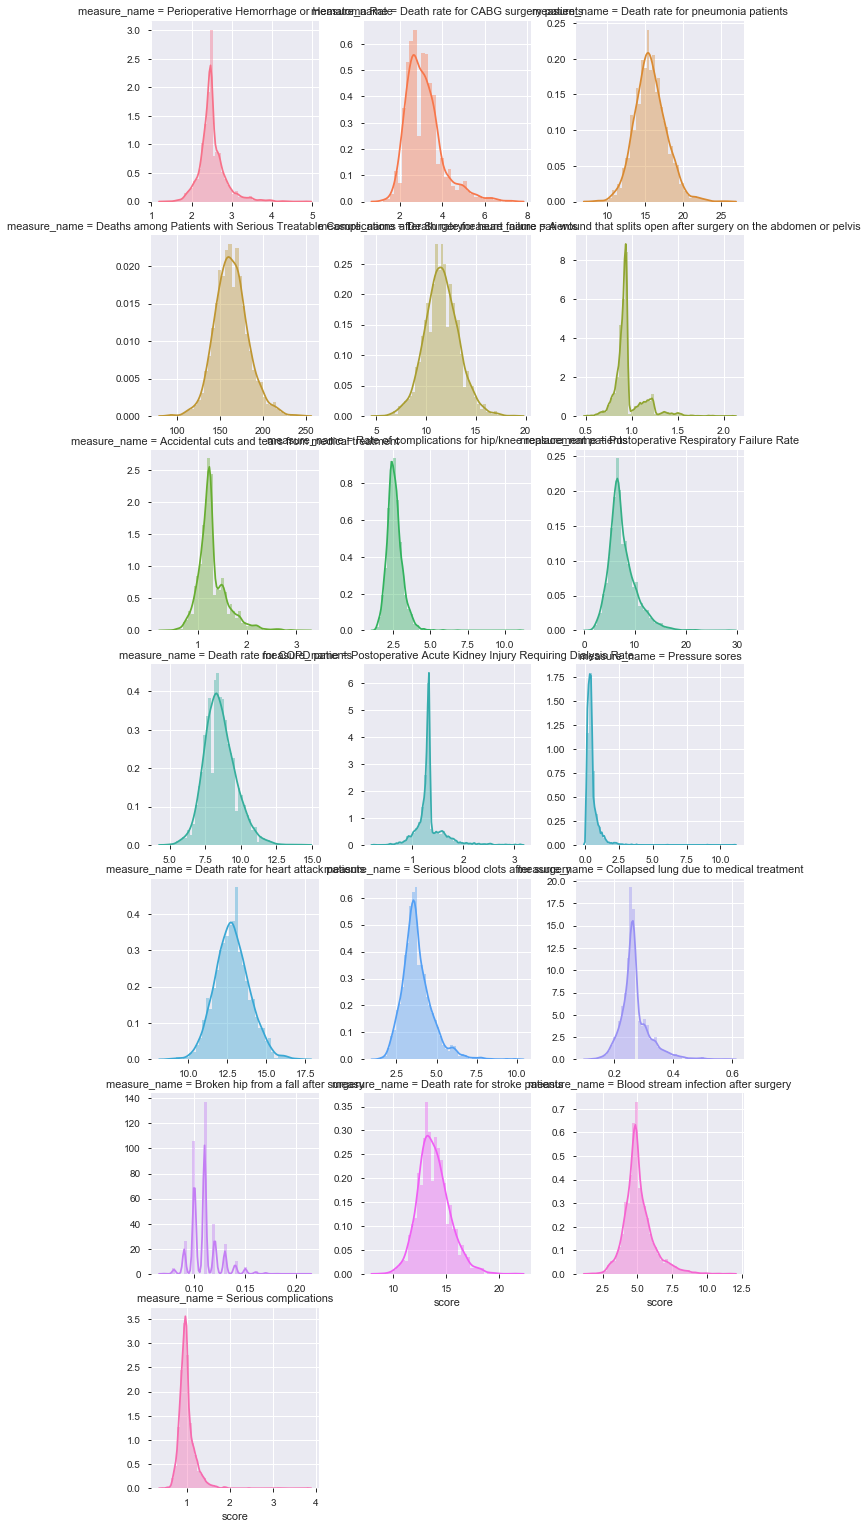

In [298]:
# How do score distributions look when faceted by measure?

g = sns.FacetGrid(comps_deaths, col="measure_name",  hue="measure_name", col_wrap=3,
                 sharey=False, sharex=False)
    
g = g.map(sns.distplot, 'score')   

**It looks like most of the measures are normal-like in their distributions (with the notable exception of broken hips after falls for some reason and a couple of other less egregious ones), but most have a significant degree of skew to them.** I'm not sure how this may impact later analysis (e.g. imputation), but it's good to keep in mind for now.

This suggests to me that there's value in treating each measure type as a unique feature, so let's do some dataframe modifications to make these measures each their own feature.

But first, let's deal with the `provider_id` column and make sure there aren't any surprises there.

In [300]:
# Check out provider_id and make sure there's no issues there that would impact later JOINs

comps_deaths[comps_deaths['provider_id'].str.contains(r'[A-Z]')]#.isnull().sum()

provider_id                                       measure_name  score  \
1444       01014F              Death rate for heart failure patients    7.7   
1445       01014F               Death rate for heart attack patients   11.5   
1446       01014F                     Death rate for stroke patients    NaN   
1447       01014F               Death rate for CABG surgery patients    NaN   
1448       01014F  Rate of complications for hip/knee replacement...    NaN   
1449       01014F                  Death rate for pneumonia patients   13.2   
1583       01019F              Death rate for heart failure patients    9.0   
1584       01019F               Death rate for heart attack patients    NaN   
1585       01019F  Rate of complications for hip/knee replacement...    NaN   
1586       01019F                     Death rate for stroke patients    NaN   
1587       01019F               Death rate for CABG surgery patients    NaN   
1588       01019F                  Death rate for pneumonia patients   15.3   
1589       01021F               Death rate for heart attack patients    NaN   
1590       01021F               Death rate for CABG surgery patients    NaN   
1591       01021F  Rate of complications for hip/knee replacement...    NaN   
1592       01021F                  Death rate for pneumonia patients    NaN   
1593       01021F              Death rate for heart failure patients    NaN   
1594       01021F                     Death rate for stroke patients    NaN   
1861       02013F                  Serious blood clots after surgery    NaN   
1862       02013F          Perioperative Hemorrhage or Hematoma Rate    NaN   
1863       02013F                       Death rate for COPD patients    NaN   
1864       02013F               Broken hip from a fall after surgery    NaN   
1865       02013F   Accidental cuts and tears from medical treatment    NaN   
1866       02013F               Death rate for heart attack patients    NaN   
1867       02013F              Death rate for heart failure patients    NaN   
1868       02013F                     Death rate for stroke patients    NaN   
1869       02013F             Postoperative Respiratory Failure Rate    NaN   
1870       02013F            Collapsed lung due to medical treatment    NaN   
1871       02013F  A wound that splits open after surgery on the ...    NaN   
1872       02013F               Blood stream infection after surgery    NaN   
...           ...                                                ...    ...   
87888      52002F              Death rate for heart failure patients   11.2   
87889      52002F                     Death rate for stroke patients    NaN   
87890      52002F  Rate of complications for hip/knee replacement...    NaN   
87891      52002F               Death rate for heart attack patients    NaN   
87892      52002F               Death rate for CABG surgery patients    NaN   
87893      52002F                  Death rate for pneumonia patients   12.2   
88008      52003F              Death rate for heart failure patients    7.5   
88009      52003F               Death rate for CABG surgery patients    NaN   
88010      52003F                     Death rate for stroke patients    NaN   
88011      52003F                  Death rate for pneumonia patients   11.9   
88012      52003F               Death rate for heart attack patients   11.6   
88013      52003F  Rate of complications for hip/knee replacement...    NaN   
88090      52004F                     Death rate for stroke patients    NaN   
88091      52004F  Rate of complications for hip/knee replacement...    NaN   
88092      52004F              Death rate for heart failure patients    9.6   
88093      52004F                  Death rate for pneumonia patients   12.2   
88094      52004F               Death rate for heart attack patients   10.7   
88095      52004F               Death rate for CABG surgery patients    NaN   
90243      53004F  Rate of complications for hip/knee re

**This is really strange.** For some reason, there are provider IDs in this dataset that don't exist in the general info dataset, and they all seem to include the letter "F". Since we're taking the `gen_info` dataset as being the gold standard here and referencing everything back to that, I'm afraid I'm going to need to drop these others. The good news is that the primary metric of interest, `compared_to_national`, seems to be mostly null for these entries anyhow (76% of them missing), so likely we're not losing a lot of information by dropping them.

I'll also modify `query_CMS` so that it can optionally be set to drop any records with provider ID values not in `gen_info`

In [301]:
# Drop the unknown provider IDs

bad_IDs = comps_deaths[~comps_deaths['provider_id'].isin(valid_IDs)].index
comps_deaths.drop(index=bad_IDs, inplace=True)

In [302]:
# Push provider IDs to int type
comps_deaths['provider_id'] = comps_deaths['provider_id'].astype(int)

In [303]:
comps_deaths.head()

provider_id                                       measure_name   score  \
0        10001          Perioperative Hemorrhage or Hematoma Rate    2.43   
1        10001               Death rate for CABG surgery patients    4.30   
2        10001                  Death rate for pneumonia patients   17.00   
3        10001  Deaths among Patients with Serious Treatable C...  163.11   
4        10001              Death rate for heart failure patients   12.70   

  measure_start_date measure_end_date      Dataset Last Updated  
0         2016-07-01       2018-06-30 2019-07-30 06:19:15+00:00  
1         2015-07-01       2018-06-30 2019-07-30 06:19:15+00:00  
2         2015-07-01       2018-06-30 2019-07-30 06:19:15+00:00  
3         2016-07-01       2018-06-30 2019-07-30 06:19:15+00:00  
4         2015-07-01       2018-06-30 2019-07-30 06:19:15+00:00

Great, that's taken care of. Now let's deal with expanding `measure_name` and `score` into new measure-specific features.

In [305]:
comps_deaths.pivot(index = 'provider_id', columns='measure_name', 
                   values='score')

measure_name  A wound that splits open after surgery on the abdomen or pelvis  \
provider_id                                                                     
10001                                                      0.76                 
10005                                                      1.17                 
10006                                                      0.82                 
10007                                                      0.95                 
10008                                                       NaN                 
10011                                                      1.10                 
10012                                                      0.92                 
10016                                                      1.09                 
10018                                                       NaN                 
10019                                                      0.90                 
10021                                                      0.94                 
10022                                                       NaN                 
10023                                                      1.12                 
10024                                                      1.13                 
10029                                                      0.82                 
10032                                                       NaN                 
10033                                                      0.89                 
10034                                                      0.95                 
10035                                                      1.46                 
10036                                                      0.92                 
10038                                                      0.93                 
10039                                                      1.20                 
10040                                                      0.85                 
10044                                                       NaN                 
10045                                                       NaN                 
10046                                                      0.90                 
10047                                                       NaN                 
10049                                                      0.92                 
10051                                                       NaN                 
10052                                                       NaN                 
...                                                         ...                 
670085                                                     0.93                 
670087                                                      NaN                 
670088                                                     0.88                 
670090                                                      NaN                 
670093                                                      NaN                 
670094                                                      NaN                 
670095                                                      NaN                 
670097                                                      NaN                 
670098                                                     1.52                 
670099                                                      NaN                 
670102                                                      NaN                 
670103                                                     0.94                 
670106                                                     0.95                 
670107                                                      NaN                 
670108                                                     0.93                 
670109                                                      NaN                 
670110                         

In [307]:
# How many nulls for each new column as a % of the total possible rows?

(comps_deaths.pivot(index='provider_id', columns='measure_name', values='score')\
.dropna(how='all').isnull().sum() / comps_deaths['provider_id'].nunique()).sort_values()

measure_name
Death rate for pneumonia patients                                           0.062421
Death rate for COPD patients                                                0.162043
Death rate for heart failure patients                                       0.172131
Serious complications                                                       0.230979
Collapsed lung due to medical treatment                                     0.235813
Broken hip from a fall after surgery                                        0.236654
Pressure sores                                                              0.240647
Serious blood clots after surgery                                           0.281421
Perioperative Hemorrhage or Hematoma Rate                                   0.282472
Accidental cuts and tears from medical treatment                            0.286885
Postoperative Acute Kidney Injury Requiring Dialysis Rate                   0.324506
Blood stream infection after surgery                

This isn't great, but it isn't the end of the world. Looks like our best case scenario is 6% missing values and our worst case is 70% missing. That's definitely something we can impute when the time comes. 

**Even though it will require me to drop a non-trivial number of hospitals in analysis, one interesting question I'd like to answer is: what are the hallmarks of a hospital that sees a higher-than-average number of deaths among patients with serious treatable complications after surgery?** I'm interested in this one because it seems like it captures the nature of complications and mortality rates nicely in one metric: why are we seeing higher-than-normal deaths due to surgical complications? That seems like a highly relevant question that any discerning surgical patient would like answered!

OK, let's take a look at the measurement start and end dates, to see if there's something simple we can do as we reduce this table to a one-row-per-hospital structure to retain their information.

In [312]:
comps_deaths.head()

provider_id                                       measure_name   score  \
0        10001          Perioperative Hemorrhage or Hematoma Rate    2.43   
1        10001               Death rate for CABG surgery patients    4.30   
2        10001                  Death rate for pneumonia patients   17.00   
3        10001  Deaths among Patients with Serious Treatable C...  163.11   
4        10001              Death rate for heart failure patients   12.70   

  measure_start_date measure_end_date      Dataset Last Updated  
0         2016-07-01       2018-06-30 2019-07-30 06:19:15+00:00  
1         2015-07-01       2018-06-30 2019-07-30 06:19:15+00:00  
2         2015-07-01       2018-06-30 2019-07-30 06:19:15+00:00  
3         2016-07-01       2018-06-30 2019-07-30 06:19:15+00:00  
4         2015-07-01       2018-06-30 2019-07-30 06:19:15+00:00

In [308]:
# Modify comps_deaths to be as simple as possible 
# while pivoting out those new measure features from earlier

# Are all measure start and end dates the same for a single provider_id?
comps_deaths.groupby('provider_id').nunique()

provider_id  measure_name  score  measure_start_date  \
provider_id                                                         
10001                  1            19     18                   3   
10005                  1            19     18                   3   
10006                  1            19     19                   3   
10007                  1            19     16                   3   
10008                  1            19      7                   3   
10011                  1            19     19                   3   
10012                  1            19     16                   3   
10016                  1            19     18                   3   
10018                  1            19      9                   3   
10019                  1            19     14                   3   
10021                  1            19     14                   3   
10022                  1            19      6                   3   
10023                  1            19     19                   3   
10024                  1            19     19                   3   
10029                  1            19     19                   3   
10032                  1            19      6                   3   
10033                  1            19     19                   3   
10034                  1            19     12                   3   
10035                  1            19     18                   3   
10036                  1            19     14                   3   
10038                  1            19     17                   3   
10039                  1            19     19                   3   
10040                  1            19     19                   3   
10044                  1            19      7                   3   
10045                  1            19     10                   3   
10046                  1            19     19                   3   
10047                  1            19      0                   3   
10049                  1            19     16                   3   
10051                  1            19      4                   3   
10052                  1            19      6                   3   
...                  ...           ...    ...                 ...   
670085                 1            19     17                   3   
670087                 1            19      1                   3   
670088                 1            19     19                   3   
670090                 1            19      8                   3   
670093                 1            19      2                   3   
670094                 1            19      3                   3   
670095                 1            19      1                   3   
670097                 1            19      3                   3   
670098                 1            19     14                   3   
670099                 1            19      0                   3   
670102                 1            19      0                   3   
670103                 1            19     15                   3   
670106                 1            19     14                   3   
670107                 1            19      4                   3   
670108                 1            19     15                   3   
670109                 1            19      0                   3   
670110                 1            19     10                   3   
670112                 1            19     11                   3   
670113                 1            19      0                   3   
670115                 1            19      0                   3   
670116                 1            19     10                   3   
670117                 1            19      1                   3   
670118                 1            19      4                   3   
670119                 1            19     10                   3   
670120                 1            19     12                   3   
670121     

In [309]:
comps_deaths['measure_start_date'].value_counts()

2016-07-01    57096
2015-07-01    28548
2015-04-01     4758
Name: measure_start_date, dtype: int64

In [310]:
comps_deaths['measure_end_date'].value_counts()

2018-06-30    85644
2018-03-31     4758
Name: measure_end_date, dtype: int64

Bollocks. It looks like we can't retain the measurement date information when we aggregate it so every row is a unique hospital. Given how tight the distribution of dates for the measures is, and my lack of intent to actually do time series analysis on this, I think we don't need to worry about this. Moving on!

In [311]:
last_updated = comps_deaths.loc[0, 'Dataset Last Updated']
last_updated

Timestamp('2019-07-30 06:19:15+0000', tz='UTC')

In [314]:
# Redefine comps_deaths to have a column for every unique measure

comps_deaths = comps_deaths.pivot(index = 'provider_id', columns='measure_name', 
                                  values='score')

# Add back in the Dataset Last Updated column
comps_deaths['Dataset Last Updated'] = last_updated
comps_deaths.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4758 entries, 10001 to 670126
Data columns (total 20 columns):
A wound that splits open after surgery on the abdomen or pelvis             2743 non-null float64
Accidental cuts and tears from medical treatment                            2944 non-null float64
Blood stream infection after surgery                                        2745 non-null float64
Broken hip from a fall after surgery                                        3183 non-null float64
Collapsed lung due to medical treatment                                     3187 non-null float64
Death rate for CABG surgery patients                                        1005 non-null float64
Death rate for COPD patients                                                3538 non-null float64
Death rate for heart attack patients                                        2269 non-null float64
Death rate for heart failure patients                                       3490 non-null float64
Death

In [315]:
pdp.ProfileReport(comps_deaths)

## Healthcare Associated Infections

This is another one that is potentially fertile ground for finding a good target variable. Let's see what we've got to work with!

In [319]:
hai = query_CMS(metadata.loc[3, 'API Endpoint URL'], 
                drop_location_data=True,
                gold_standard_IDs=valid_IDs)
hai.head(20)

Query successful!


provider_id                     hospital_name  \
0         10001  SOUTHEAST ALABAMA MEDICAL CENTER   
1         10001  SOUTHEAST ALABAMA MEDICAL CENTER   
2         10001  SOUTHEAST ALABAMA MEDICAL CENTER   
3         10001  SOUTHEAST ALABAMA MEDICAL CENTER   
4         10001  SOUTHEAST ALABAMA MEDICAL CENTER   
5         10001  SOUTHEAST ALABAMA MEDICAL CENTER   
6         10001  SOUTHEAST ALABAMA MEDICAL CENTER   
7         10001  SOUTHEAST ALABAMA MEDICAL CENTER   
8         10001  SOUTHEAST ALABAMA MEDICAL CENTER   
9         10001  SOUTHEAST ALABAMA MEDICAL CENTER   
10        10001  SOUTHEAST ALABAMA MEDICAL CENTER   
11        10001  SOUTHEAST ALABAMA MEDICAL CENTER   
12        10001  SOUTHEAST ALABAMA MEDICAL CENTER   
13        10001  SOUTHEAST ALABAMA MEDICAL CENTER   
14        10001  SOUTHEAST ALABAMA MEDICAL CENTER   
15        10001  SOUTHEAST ALABAMA MEDICAL CENTER   
16        10001  SOUTHEAST ALABAMA MEDICAL CENTER   
17        10001  SOUTHEAST ALABAMA MEDICAL CENTER   
18        10001  SOUTHEAST ALABAMA MEDICAL CENTER   
19        10001  SOUTHEAST ALABAMA MEDICAL CENTER   

                                         measure_name       measure_id  \
0   Central Line Associated Bloodstream Infection:...       HAI_1_DOPC   
1   Clostridium Difficile (C.Diff): Lower Confiden...    HAI_6_CILOWER   
2        Clostridium Difficile (C.Diff): Patient Days       HAI_6_DOPC   
3   Catheter Associated Urinary Tract Infections (...       HAI_2_DOPC   
4                SSI - Colon Surgery: Predicted Cases  HAI_3_ELIGCASES   
5       SSI - Abdominal Hysterectomy: Predicted Cases  HAI_4_ELIGCASES   
6   Catheter Associated Urinary Tract Infections (...  HAI_2_ELIGCASES   
7   Clostridium Difficile (C.Diff): Upper Confiden...    HAI_6_CIUPPER   
8   Central Line Associated Bloodstream Infection ...  HAI_1_ELIGCASES   
9   SSI - Abdominal Hysterectomy: Lower Confidence...    HAI_4_CILOWER   
10                       SSI - Abdominal Hysterectomy        HAI_4_SIR   
11                    MRSA Bacteremia: Observed Cases  HAI_5_NUMERATOR   
12            MRSA Bacteremia: Lower Confidence Limit    HAI_5_CILOWER   
13  Catheter Associated Urinary Tract Infections (...        HAI_2_SIR   
14  Catheter Associated Urinary Tract Infections (...    HAI_2_CILOWER   
15                SSI - Colon Surgery: Observed Cases  HAI_3_NUMERATOR   
16  Central Line Associated Bloodstream Infection ...    HAI_1_CILOWER   
17       SSI - Abdominal Hysterectomy: Observed Cases  HAI_4_NUMERATOR   
18  Central Line Associated Bloodstream Infection ...    HAI_1_CIUPPER   
19            MRSA Bacteremia: Upper Confidence Limit    HAI_5_CIUPPER   

                    compared_to_national   score       measure_start_date  \
0   No Different than National Benchmark    7283  2017-10-01T00:00:00.000   
1     Better than the National Benchmark   0.295  2017-10-01T00:00:00.000   
2     Better than the National Benchmark   94830  2017-10-01T00:00:00.000   
3   No Different than National Benchmark   13269  2017-10-01T00:00:00.000   
4     Better than the National Benchmark   4.763  2017-10-01T00:00:00.000   
5   No Different than National Benchmark   1.809  2017-10-01T00:00:00.000   
6   No Different than National Benchmark  14.786  2017-10-01T00:00:00.000   
7     Better than the National Benchmark   0.606  2017-10-01T00:00:00.000   
8   No Different than National Benchmark   6.179  2017-10-01T00:00:00.000   
9   No Different than National Benchmark      --  2017-10-01T00:00:00.000   
10  No Different than National Benchmark   0.000  2017-10-01T00:00:00.000   
11    Better than the National Benchmark       1  2017-10-01T00:00:00.000   
12    Better than the National Benchmark   0.009  2017-10-01T00:00:00.000   
13  No Different than National Benchmark   1.082  2017-10-01T00:00:00.000   
14  No Different than National Benchmark   0.641  2017-10-01T00:00:00.000   
15    Better than the National Benchmark       0  2017-10-01T00:00:00.000   
16  No Different than Nati

In [321]:
# hospital_name is redundant with provider_id, so drop it
hai.drop(columns=['hospital_name'], inplace=True)

In [322]:
hai.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171288 entries, 0 to 171287
Data columns (total 8 columns):
provider_id             171288 non-null int64
measure_name            171288 non-null object
measure_id              171288 non-null object
compared_to_national    69798 non-null object
score                   99331 non-null object
measure_start_date      171288 non-null object
measure_end_date        171288 non-null object
Dataset Last Updated    171288 non-null datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), int64(1), object(6)
memory usage: 11.8+ MB


## Hospital Readmissions



## Medicare Spending Per Beneficiary



## Outpatient Imaging Efficiency



## Patient Survey (HCAHPS)



## Hospital Structural Measures

